# DSCI 591: Data Science Capstone I <br> EDA on FLAME 1 Boundary Detection Dataset

## Project Objective

1. Build model to detect the presence of forest fires
2. Build model to detect border / boundary of forest fire

## Primary Use Case

Park rangers pilot drones to at-risk locations for surveillance and early fire detection. Data is relayed as input for the model.

## Description of Data

1. **Primary Use:** Primary Modeling Dataset
2. **Summary:** Contains raw video and processed images from a controlled burn in an Arizona pine forest. Specifically, there are video recordings and thermal heatmaps (infrared cameras).
3. **Link:** https://paperswithcode.com/dataset/flame

## List of Files within Dataset

1. Raw Video (All)
        a. File Type: MP4
        b. Description: 966s footage from Zenmuse X4S camera
2. Raw Video (Specific Burn Patch)
        a. File Type: MP4
        b. Description: 400s footage from Zenmuse X4S camera
3. Raw Video (thermal - White Hot)
        a. File Type: MOV
        b. Description: 89s footage from FLIR Vue Pro R thermal camera     
4. Raw Video (thermal - Green Hot)
        a. File Type: MOV
        b. Description: 305s from FLIR Vue Pro R thermal camera
5. Raw Video (thermal fusion)
        a. File Type: MOV
        b. Description: 25-min footage from FLIR Vue Pro R thermal camera
6. Raw Video (Phantom Drone)
        a. File Type: MOV
        b. Description: 17-min footage from DJI Phantom 3 camera
7. Training / Validation Images (Classification)
        a. File Type: JPG
        b. Description: 39,375 frames, either “Fire” or “No Fire”
8. Test Images (Classification)
        a. File Type: JPG
        b. Description: 8,617 frames, either “Fire” or “No Fire”
9. Images (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 frames for Train / Test / Val
10. Masks Annotation (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 ground truth mask frames for Train / Test / Val

## Exploratory Data Analysis (EDA)

In [4]:
#Relevant Libraries
from pathlib import Path
import pandas as pd
import cv2
import os
import re
import numpy as np
from PIL import Image
from IPython.display import Image as Image_dis
import hvplot.pandas
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tqdm import tqdm

In [5]:
#Install OpenCV package: https://pypi.org/project/opencv-python/
!pip install opencv-python
#Install HVPlot package: https://hvplot.holoviz.org/user_guide/Pandas_API.html
!pip install hvplot

### Importing the Data

As with the Classification dataset, we first need to establish local directories to our segmentation frames and masks.

In [6]:
## Set current directories for segmentation frames and masks
local_seg_frame_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Images"
local_seg_mask_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Masks"

Next, we will slightly modify some of the classification functions to create an initial dataframes for the segmentation frames and masks. These will largely remain the same, though.

In [9]:
#Create a function to grab the dimensions (pixels) and channels (color or b&w) of files
#NOTE: Same function as that for Classification dataset
def get_dimensions_and_channels(file_string):
    image = cv2.imread(file_string)
    height, width, channel = image.shape
    
    return height, width, channel

#Create a function to tokenize the file name strings, returning a unique id and type of file
#NOTE: Difference is that we do not have classes to iterate through
def seg_tokenize_file_name(filename_string):
    tokens = re.split("_", filename_string)
    token_of_interest = tokens[-1]
    tokenizing = re.split("\.", token_of_interest)
    file_id = tokenizing[0]
    file_type = tokenizing[-1]
    
    return file_id, file_type

#Create a function that does all of the collection / aggregation for a given path
#NOTE: Difference is we do not have classes to iterate through
def seg_collect_aggregate_df(file_dir):
    metadata = []
    
    for item in os.listdir(file_dir):
        item_name = item
        item_id, item_type = seg_tokenize_file_name(item)
        item_path = os.path.join(file_dir, item)
        item_height, item_width, item_channel = get_dimensions_and_channels(item_path)

        metadata.append([item_id, item_type, item_height, item_width, item_channel, item_name, item_path])
            
    return metadata

In [10]:
### FRAME DATA COLLECTION/AGGREGATION ###
seg_frame_metadata = []

seg_frame_metadata = seg_collect_aggregate_df(local_seg_frame_dir)

In [12]:
### MASK DATA COLLECTION/AGGREGATION ###
seg_mask_metadata = []

seg_mask_metadata = seg_collect_aggregate_df(local_seg_mask_dir)

With our frame and mask data aggregated into lists for metadata, we will follow the same process as with the classification dataset and convert them into dataframes. Then, we will examine these to make sure we have done the process correctly.

In [13]:
### FRAME DATAFRAME CREATION ###
seg_frame_df = pd.DataFrame(seg_frame_metadata, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path'])

In [14]:
### Examine frame dataframe head ###
seg_frame_df.head(5)

id file_type  pixel_height  pixel_width  image_channels       file_name  \
0     0       jpg          2160         3840               3     image_0.jpg   
1     1       jpg          2160         3840               3     image_1.jpg   
2    10       jpg          2160         3840               3    image_10.jpg   
3   100       jpg          2160         3840               3   image_100.jpg   
4  1000       jpg          2160         3840               3  image_1000.jpg   

                                           file_path  
0  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
1  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
2  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
3  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
4  C:\Users\ConnorRoth\Documents\Grad School\Spri...

In [15]:
### Examine frame dataframe size ###
seg_frame_df.shape

(2003, 7)

In [16]:
### MASK DATAFRAME CREATION ###
seg_mask_df = pd.DataFrame(seg_mask_metadata, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path'])

In [17]:
### Examine mask dataframe head ###
seg_mask_df.head(5)

id file_type  pixel_height  pixel_width  image_channels       file_name  \
0     0       png          2160         3840               3     image_0.png   
1     1       png          2160         3840               3     image_1.png   
2    10       png          2160         3840               3    image_10.png   
3   100       png          2160         3840               3   image_100.png   
4  1000       png          2160         3840               3  image_1000.png   

                                           file_path  
0  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
1  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
2  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
3  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
4  C:\Users\ConnorRoth\Documents\Grad School\Spri...

In [18]:
### Examine mask dataframe size ###
seg_mask_df.shape

(2003, 7)

Overall, the thing that most sticks out is the sheer size of the pixels. As students, we do not have access to suffuciently powerful GPUs to analyze and work with this data. So, we will need to write code to downsize all images as we process them in order to prevent memory overflow.

In [19]:
#Read listed images and masks
def generate_sorted_paths(local_seg_frame_dir, local_seg_mask_dir):
    frame_paths = sorted([os.path.join(local_seg_frame_dir, fname) 
                          for fname in tqdm(os.listdir(local_seg_frame_dir)) 
                          if fname.endswith(".jpg")])
    mask_paths = sorted([os.path.join(local_seg_mask_dir, fname) 
                         for fname in tqdm(os.listdir(local_seg_mask_dir)) 
                         if fname.endswith(".png") and not fname.startswith(".")])
    
    return frame_paths, mask_paths

In [20]:
frame_paths, mask_paths = generate_sorted_paths(local_seg_frame_dir, local_seg_mask_dir)

100%|██████████| 2003/2003 [00:00<00:00, 286270.86it/s]


In [21]:
#Establish new image size - scaling down from prior
img_size = (512, 512)
img_width = 512
img_height = 512
img_channels = 3
    
#Establish zeroed numpy arrays to fill in - frame will be int8, masks will be boolean
seg_frame_images = np.zeros((len(frame_paths), img_height, img_width, img_channels), dtype=np.uint8)
seg_mask_images = np.zeros((len(mask_paths), img_height, img_width, 1), dtype=bool)

def seg_tokenize_file_name(filename_string):
    tokens = re.split("\\\\", filename_string)
    file_name = tokens[-1]
    file_name_tokens = re.split("_", file_name)
    token_of_interest = file_name_tokens[-1]
    tokenizing = re.split("\.", token_of_interest)
    file_id = tokenizing[0]
    file_type = tokenizing[-1]
    
    return file_name, file_id, file_type

#FRAME DATA - Create a function that does all of the collection / aggregation for a given path
def seg_collect_aggregate_frame_data(frame_paths):
    metadata = []
    
    for n, item in tqdm(enumerate(frame_paths)):
        item_path = item
        item_name, item_id, item_type = seg_tokenize_file_name(item)
        item_height, item_width, item_channel = img_height, img_width, img_channels
        item_img = tf.keras.preprocessing.image.load_img(item, target_size = img_size)
        
        seg_frame_images[n] = item_img
        metadata.append([item_id, item_type, item_height, item_width, item_channel, item_name, item_path])
            
    return metadata


#MASK DATA - Create a function that does all of the collection / aggregation for a given path
def seg_collect_aggregate_mask_data(mask_paths):
    metadata = []
    
    for n, item in tqdm(enumerate(mask_paths)):
        item_path = item
        item_name, item_id, item_type = seg_tokenize_file_name(item)
        item_height, item_width, item_channel = img_height, img_width, 1
        item_img = tf.keras.preprocessing.image.load_img(item, target_size=img_size, color_mode="grayscale")
        
        seg_mask_images[n] = np.expand_dims(item_img, axis=2)
        metadata.append([item_id, item_type, item_height, item_width, item_channel, item_name, item_path])
            
    return metadata

In [22]:
### FRAME DATA COLLECTION/AGGREGATION ###
seg_frame_metadata = []

seg_frame_metadata = seg_collect_aggregate_frame_data(frame_paths)

2003it [03:05, 10.80it/s]


In [23]:
### MASK DATA COLLECTION/AGGREGATION ###
seg_mask_metadata = []

seg_mask_metadata = seg_collect_aggregate_mask_data(mask_paths)

2003it [00:27, 72.87it/s]


In [24]:
### FRAME DATAFRAME CREATION ###
seg_frame_df = pd.DataFrame(seg_frame_metadata, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path'])

In [25]:
### Examine frame dataframe head ###
seg_frame_df.head(5)

id file_type  pixel_height  pixel_width  image_channels       file_name  \
0     0       jpg           512          512               3     image_0.jpg   
1     1       jpg           512          512               3     image_1.jpg   
2    10       jpg           512          512               3    image_10.jpg   
3   100       jpg           512          512               3   image_100.jpg   
4  1000       jpg           512          512               3  image_1000.jpg   

                                           file_path  
0  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
1  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
2  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
3  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
4  C:\Users\ConnorRoth\Documents\Grad School\Spri...

In [26]:
### Examine frame dataframe size ###
seg_frame_df.shape

(2003, 7)

In [27]:
### Examine Shape of Seg Frame Image Array ###
print("Segmentation Frame Image array shape:", seg_frame_images.shape)

Segmentation Frame Image array shape: (2003, 512, 512, 3)


In [28]:
### MASK DATAFRAME CREATION ###
seg_mask_df = pd.DataFrame(seg_mask_metadata, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path'])

In [29]:
### Examine mask dataframe head ###
seg_mask_df.head(5)

id file_type  pixel_height  pixel_width  image_channels       file_name  \
0     0       png           512          512               1     image_0.png   
1     1       png           512          512               1     image_1.png   
2    10       png           512          512               1    image_10.png   
3   100       png           512          512               1   image_100.png   
4  1000       png           512          512               1  image_1000.png   

                                           file_path  
0  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
1  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
2  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
3  C:\Users\ConnorRoth\Documents\Grad School\Spri...  
4  C:\Users\ConnorRoth\Documents\Grad School\Spri...

In [30]:
### Examine mask dataframe size ###
seg_mask_df.shape

(2003, 7)

In [31]:
### Examine Shape of Seg Mask Image Array ###
print("Segmentation Mask Image array shape:", seg_mask_images.shape)

Segmentation Mask Image array shape: (2003, 512, 512, 1)


### View Sampling of Images

Now, we want to get a bit of a sense of what the images and masks actually look like. So, we will modify our previous functions to get a better sense of this.

In [32]:
#Show random sampling of 10 images from our dataset with the corresponding mask
def seg_show_random_sampling(seg_frame_images, seg_mask_images):
    for i in range(0, 10):
        idx_rand = random.randint(0, len(frame_paths))
        plt.figure(figsize=(13, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(seg_frame_images[idx_rand])
        plt.axis('off')
        plt.title(str('Image: ' + str(idx_rand)))
        
        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(seg_mask_images[idx_rand]))
        plt.axis('off')
        plt.title(str('Mask: ' + str(idx_rand)))
        
        plt.show()

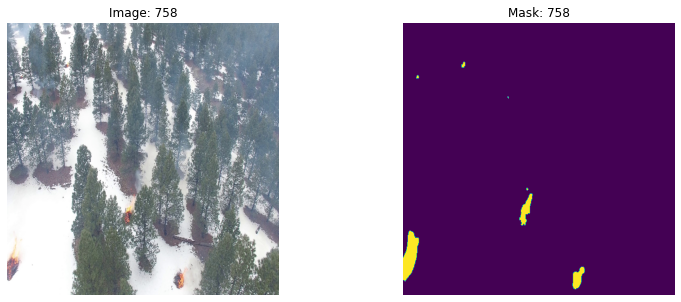

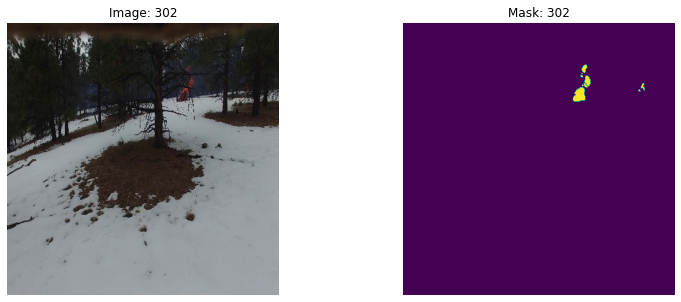

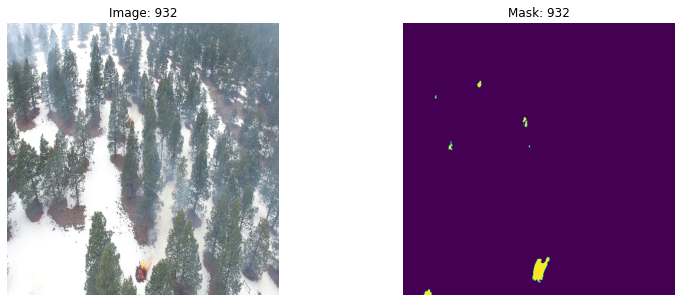

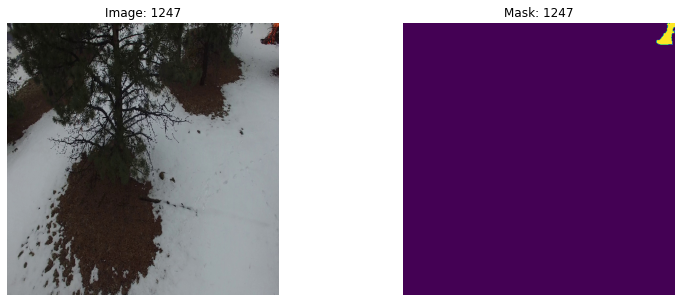

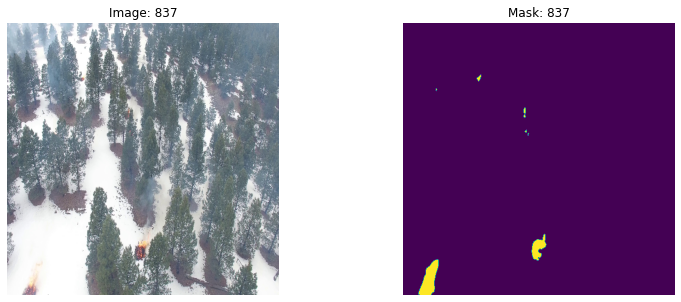

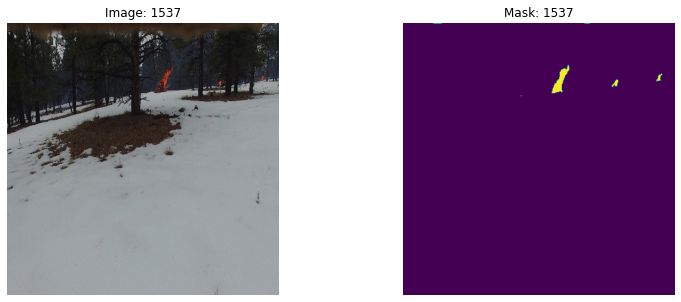

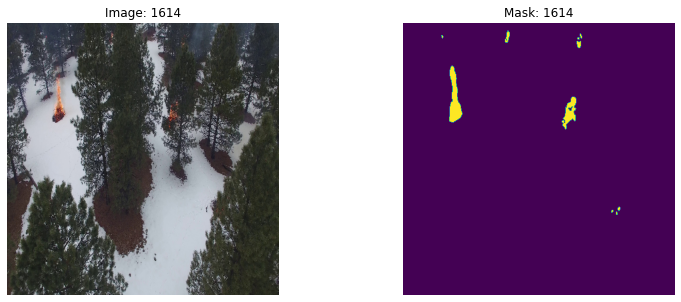

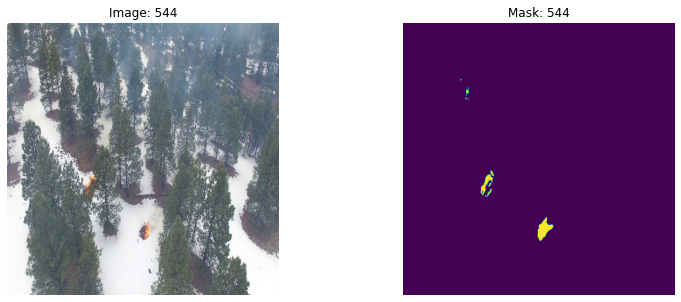

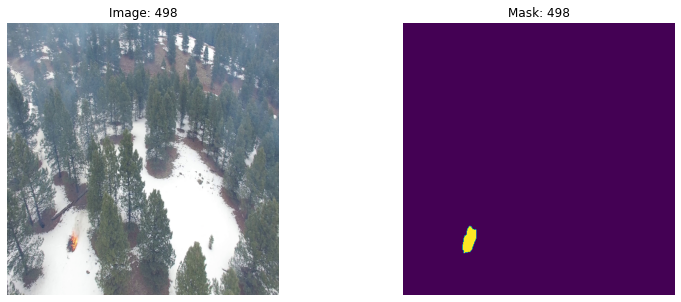

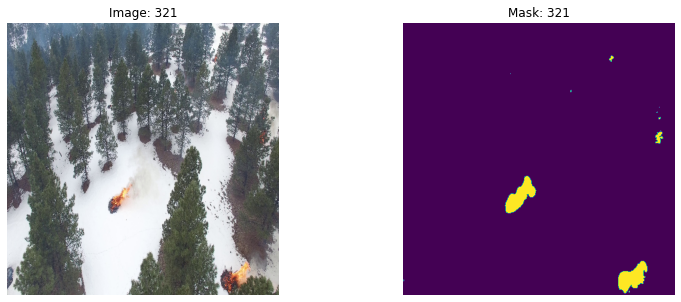

In [33]:
seg_show_random_sampling(seg_frame_images, seg_mask_images)

Overall, we can see that the masking is done quite well, as they line up in a 1-to-1 manner with the original images. Though, it may prove difficult for training purposes, given how small some of the fires are (as these images are taken at altitude).

### Examine Image Sizing (Graphically)

Next, we will double-check that our images are all of the expected size. As mentioned earlier, we needed to downsize these to 512x512. So, we will check this both with the dataframe and image arrays.

In [34]:
# FRAME - Check height, width, and channels
print("FRAME Dataset Unique Values:")
print("FRAME Pixel Height:", seg_frame_df["pixel_height"].unique())
print("FRAME Pixel Width:", seg_frame_df["pixel_width"].unique())
print("FRAME Image Channels:", seg_frame_df["image_channels"].unique())

FRAME Dataset Unique Values:
FRAME Pixel Height: [512]
FRAME Pixel Width: [512]
FRAME Image Channels: [3]


In [35]:
# MASK - Check height, width, and channels
print("MASK Dataset Unique Values:")
print("MASK Pixel Height:", seg_mask_df["pixel_height"].unique())
print("MASK Pixel Width:", seg_mask_df["pixel_width"].unique())
print("MASK Image Channels:", seg_mask_df["image_channels"].unique())

MASK Dataset Unique Values:
MASK Pixel Height: [512]
MASK Pixel Width: [512]
MASK Image Channels: [1]


In [36]:
## FRAME - Graphing height against width
sizes = seg_frame_df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

In [37]:
## MASK - Graphing height against width
sizes = seg_mask_df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

As expected, these images are all of size 512x512. So, our downsizing worked as intended!

### Examine Pixel Data (RGB channels) for Frame Data

Now, we will take a look at the pixel intensities for the frame data. We will not be analyzing the mask data since it is a collection of boolean values with only a single channel.

In [38]:
# Create a graphing function for a histogram of red/blue/green channel values
# NOTE: Same as Classification dataset version
def plot_channel_values(title, image_array, channel, color):
    plt.hist(image_array[:,:,channel].ravel(), bins=256, color = color)
    plt.title(title)
    plt.xlabel(color + ' intensity')
    plt.ylabel('Frequency')
    plt.show()

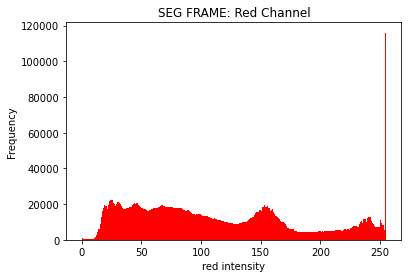

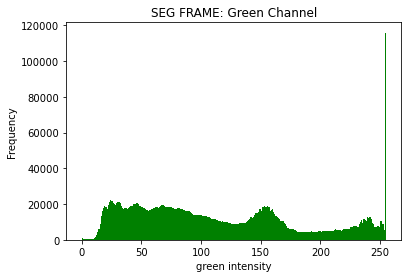

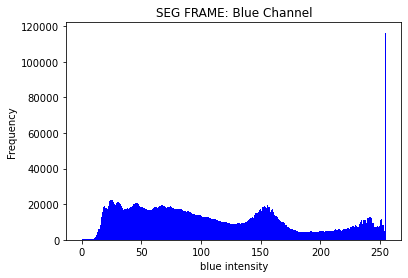

In [39]:
# SEG FRAME: Red Channel
#NOTE: Order is flipped here since Keras' load_img works in RGB: https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img
plot_channel_values("SEG FRAME: Red Channel", seg_frame_images, 0, 'red')

# SEG FRAME: Green Channel
plot_channel_values("SEG FRAME: Green Channel", seg_frame_images, 1, 'green')

# SEG FRAME: Blue Channel
plot_channel_values("SEG FRAME: Blue Channel", seg_frame_images, 2, 'blue')

Unsurprisingly, we see a lot of high-intensity values across the RGB spectrum. This is likely due to the snow on the ground in nearly every frame taken. It also closely mirrors what we saw with the classification image dataset.

### Compute "Mean Image"

The final task here will be to compute "mean images," as we did for the classification dataset. We will need to tweak our computation function slightly due to the difference in image sizing.

In [42]:
# Create average image by building up average pixel intensities (calculating as we loop through)
# NOTE: Sizing is different for segmentation dataset versus classification
def seg_average_image_data(image_array):
    average_image = np.zeros((512, 512, 3),float)
    N = len(image_array)
    
    for index in range(0, len(image_array)):
        average_image += image_array[index]/N
    
    average_image = np.array(np.round(average_image), dtype = np.uint8)
    
    return average_image


# Creating a function to generate, save, and show the resultant file
# NOTE: No difference versus function in Classification dataset
def show_average_image(average_image, title):
    output = Image.fromarray(average_image, mode="RGB")
    imgplot = plt.imshow(output)
    plt.title(title)
    plt.xlabel("pixel width")
    plt.ylabel("pidel height")
    plt.show()

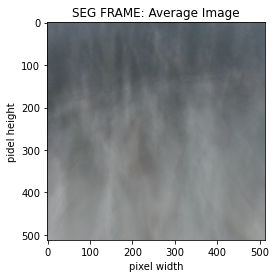

In [43]:
# SEG FRAME: Average Image
seg_frame_avg_img = seg_average_image_data(seg_frame_images)
show_average_image(seg_frame_avg_img, "SEG FRAME: Average Image")

Here, as with the classification data, we see the white of the snow against the vertical dark trunks of trees. Additionally, note that some areas are a bit more red than others (especially the bottom third) due to the angle at which the drone took the videos.